In [3]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [57]:
x = pd.read_csv("SBER_121114_201114_days.csv") #Сбер

In [58]:
x.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,SBER,D,20121114,0,85.02,85.50,83.75,84.72,92789130
1,SBER,D,20121115,0,84.00,86.36,83.85,86.09,69973470
2,SBER,D,20121116,0,85.82,86.61,85.21,85.98,64316470
3,SBER,D,20121119,0,86.61,87.60,86.12,87.34,78867650
4,SBER,D,20121120,0,87.46,87.75,86.68,87.00,51026130


In [59]:
x.columns.to_numpy()

array(['<TICKER>', '<PER>', '<DATE>', '<TIME>', '<OPEN>', '<HIGH>',
       '<LOW>', '<CLOSE>', '<VOL>'], dtype=object)

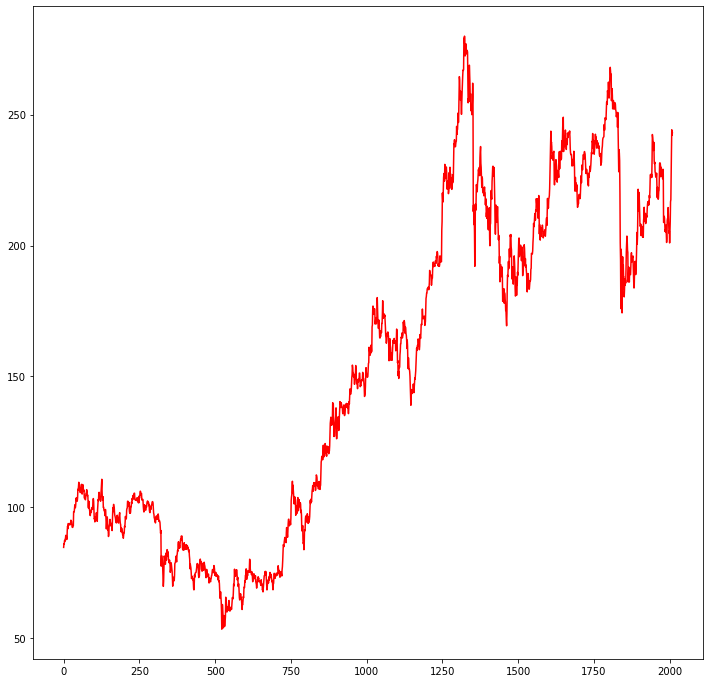

In [60]:
plt.figure(figsize=(12,12))
plt.plot(range(0, len(x["<CLOSE>"])), x["<CLOSE>"].to_numpy(), 'red')
plt.show()

In [61]:
class finance:
    def __init__(self, k_neighbors = 5, rolling_mean_window = 4, min_size = 3, eps = 0.01, metrics = 'euclidean'):
        self.rolling_mean_window = rolling_mean_window
        self.min_size = min_size
        self.eps = eps
        self.metrics = metrics
        self.k = k_neighbors
        if self.metrics == 'euclidean':
            self.distance = self.euclidean_distance
    
    def rolling_mean(self, data):
        self.rolling_mean_data = np.nan_to_num(data.rolling(self.rolling_mean_window).mean())
    
    def get_kinks(self):
        kinks=[0]
        for i in range(1, len(self.rolling_mean_data) - 1):
            if(self.rolling_mean_data[i]-self.rolling_mean_data[i-1])*(self.rolling_mean_data[i] - self.rolling_mean_data[i+1])>0:
                kinks.append(i)
        self.kinks = kinks
        
    def make_marks(self, x):
        if len(x) > 1:
            if abs(np.max(x) - np.min(x)) < self.eps:
                return 0
            else:
                return np.sign(x[0] - x[-1])
        else:
            print('Error: some length of interval <= 1')
    
    def extract_features(self, data, index):
        features = []
        for i in range(index, index + len(data)):
            features.append([data['<CLOSE>'][i] - data['<OPEN>'][i], data['<HIGH>'][i] - data['<LOW>'][i], \
                            data['<HIGH>'][i] / data['<LOW>'][i], data['<CLOSE>'][i] / data['<OPEN>'][i], \
                            np.sign(data['<CLOSE>'][i] - data['<OPEN>'][i])])   
        return features      
    
    def make_dataset(self, data):
        dataset = []
        marks = []
        for i in range(1, len(self.kinks)):
            if self.kinks[i] - self.kinks[i-1] >= self.min_size:
                dataset.append(self.extract_features(data[self.kinks[i-1] : self.kinks[i]], self.kinks[i-1]))
                marks.append(self.make_marks(self.rolling_mean_data[self.kinks[i-1] : self.kinks[i]]))
        marks.append(self.make_marks(self.rolling_mean_data[self.kinks[-1]:]))    
        # delete a little series               
        # make target
        target = marks[1:]
        return dataset, target
        
    def euclidean_distance(self, x, y):
        x = np.array(x)
        y = np.array(y)
        return np.sqrt(np.sum((x-y)**2))
    
    # when we want to predict future, we should not look there
    def right_split(self, X, y, test_size = 0.25):
        size = int(len(y) * (1 - test_size))
        X_train , y_train = X[:size], y[:size] 
        X_test , y_test = X[size:], y[size:]
        return X_train, X_test, y_train, y_test 
    
    def prepare_data(self, data):
        self.rolling_mean(data['<CLOSE>'])
        self.get_kinks()
        dataset, target = self.make_dataset(data)
        return dataset, target
    
    def predict(self, X_train, y_train, x):
        distance_list = []
        for x_train in X_train:
            min_size = min(len(x), len(x_train))
            distance_list.append(self.distance(x[len(x) - min_size : ], x_train[len(x_train) - min_size : ]))
        index = np.argsort(distance_list)[:self.k]
        marks = np.array(y_train)[index]
        marks , count = np.unique(marks, return_counts = True)
        return marks[np.argmax(count)]
        
    def fit_predict(self, X_train, y_train, X_test):
        pred = []
        for x in X_test:
            pred.append(self.predict(X_train, y_train, x))
        return pred
    
    def cross_predict(self, X_train, y_train, x):
        distance_list = []
        for x_train in X_train:
            min_size = min(len(x), len(x_train))
            distance_list.append(self.distance(x[len(x) - min_size : ], x_train[len(x_train) - min_size : ]))
        index = np.argsort(distance_list)[1:self.k + 1]
        marks = np.array(y_train)[index]
        marks , count = np.unique(marks, return_counts = True)
        return marks[np.argmax(count)]
    
    def KNN_cross_validation(self, X, y):
        pred = []
        for x in X:
            pred.append(self.cross_predict(X, y, x))
        return pred
    
    def check(self, y_predict, y_right):
        count_sum = 0
        for i in range(len(y_predict)):
            if y_predict[i] == y_right[i]:
                count_sum += 1
        return count_sum / len(y_predict)

In [62]:
first_rocket = finance(rolling_mean_window=3)
data, target = first_rocket.prepare_data(x)
pred = first_rocket.KNN_cross_validation(data, target)
first_rocket.check(pred, target)

0.6605504587155964

In [63]:
statistic = np.zeros((72, 5))
rolling_mean_window = [2, 3, 4]
k_mean = [3, 4, 5, 6, 7, 8]
min_size = [2, 3, 4, 5]
i = 0
for rol in rolling_mean_window:
    for k in k_mean:
        for m in min_size:
            first_rocket = finance(rolling_mean_window=rol, min_size = m, k_neighbors = k)
            data, target = first_rocket.prepare_data(x)
            pred = first_rocket.KNN_cross_validation(data, target)
            statistic[i] =  np.array([int(rol), int(k), int(m), first_rocket.check(pred, target), int(len(target))])
            i += 1

In [64]:
temp_index = np.argsort(statistic[:, 3])
new_stat = statistic[temp_index]
new_stat[-1:]

array([[  3.        ,   7.        ,   2.        ,   0.74055416,
        397.        ]])

In [65]:
table = pd.DataFrame(statistic, columns=['rolling mean window', 'k neighbors', 'min size', 'result', 'size of data'])

In [66]:
np.sort(table['result'])

array([0.4611399 , 0.46632124, 0.47663551, 0.47668394, 0.48704663,
       0.48909657, 0.49222798, 0.50155763, 0.5046729 , 0.50955414,
       0.51090343, 0.51152074, 0.51152074, 0.51351351, 0.51713396,
       0.52229299, 0.52252252, 0.52352941, 0.52631579, 0.52631579,
       0.52849741, 0.53153153, 0.53456221, 0.53456221, 0.53456221,
       0.53508772, 0.53603604, 0.53603604, 0.53917051, 0.54140127,
       0.54385965, 0.54504505, 0.54705882, 0.55263158, 0.55294118,
       0.55414013, 0.55414013, 0.55882353, 0.56687898, 0.58662614,
       0.5877193 , 0.58823529, 0.58823529, 0.61702128, 0.62691131,
       0.62917933, 0.62996942, 0.62996942, 0.62996942, 0.64097744,
       0.64133739, 0.6443769 , 0.64473684, 0.64575646, 0.64575646,
       0.64575646, 0.64944649, 0.65045593, 0.65137615, 0.66055046,
       0.67254408, 0.68233083, 0.68265683, 0.68421053, 0.69172932,
       0.69269521, 0.69360902, 0.69372694, 0.71536524, 0.72292191,
       0.72544081, 0.74055416])

In [67]:
table

,rolling mean window,k neighbors,min size,result,size of data
0,2.0,3.0,2.0,0.640977,532.0
1,2.0,3.0,3.0,0.510903,321.0
2,2.0,3.0,4.0,0.466321,193.0
3,2.0,3.0,5.0,0.526316,114.0
4,2.0,4.0,2.0,0.644737,532.0
...,...,...,...,...,...
67,4.0,7.0,5.0,0.588235,170.0
68,4.0,8.0,2.0,0.650456,329.0
69,4.0,8.0,3.0,0.682657,271.0
70,4.0,8.0,4.0,0.513514,222.0


In [68]:
table.to_excel('stat_sber_days.xlsx')